## To Do: 
* Update triplet function to get_imposters, get_target neighbors, that both return lookup tables. 
* Update Gradient Chi 

# Metric Learning - LMNN

In [1]:
import sklearn.metrics as sk_metrics
import sklearn.decomposition as sk_decomp
import numpy as np
import Model
import Plots
from sklearn.utils.extmath import softmax

# We ignore divisions by 0. We will do that in the chi square distance, but we don't care. 
np.seterr(divide='ignore', invalid='ignore')

Using TensorFlow backend.


{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

Underneath you can define the hyperparameters, l, mu and K.
* $l$ is the margin parameter
* $\mu$ is a trade-off parameter between the push and pull in the loss function
* $K$ is the number of target neighbors 
* $D$ is the dimensionality of our data. We choose that arbitrarily
* $L$ is the linear transformation

L is set to be a diagonal matrix of ones to begin with. However, it would be interesting to experiement with other initial L matrices, since the problem is non-convex. We could also try to implement the constrained non-convex version of LMNN.

In [2]:
l = 0.005
mu = 0.5
K = 3
D = 40
L = np.eye(D, dtype=float)
alpha = 0.001

## Data Import & Analysis

In [3]:
high_dim_embeddings, labels = Model.get_data()
s_score = sk_metrics.silhouette_score(high_dim_embeddings.T, labels, metric='euclidean')

print("Shape of embeddings is: {}".format(np.shape(high_dim_embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

Shape of embeddings is: (2048, 100)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6774616837501526


Next we need to do some dimensionality reduction. It turns out that having 2048 dimensions in the feature vector is not a good idea. Who could have predicted that? Therefore we visit our friend PCA. 

By runnning the next block, you reduce the dimensions corresponding to the F variable defined earlier. 

In [4]:
pca = sk_decomp.PCA(n_components=D)
pca.fit(high_dim_embeddings.T)
embeddings = pca.transform(high_dim_embeddings.T)
print(np.shape(np.sum(embeddings, axis=1)))
embeddings = abs(embeddings)
embeddings = (embeddings.T / np.sum(embeddings, axis=1)).T
s_score = sk_metrics.silhouette_score(embeddings, labels, metric='euclidean')

print("Explained variance of low dimensional data is: {}".format(sum(pca.explained_variance_ratio_)))
print("Shape of embeddings is: {}".format(np.shape(embeddings)))
print("Shape of labels is: {} ".format(np.shape(labels)))
print("Silhouette Score of data is: {}".format(s_score))

(100,)
Explained variance of low dimensional data is: 0.987637652317062
Shape of embeddings is: (100, 40)
Shape of labels is: (100,) 
Silhouette Score of data is: 0.6577420234680176


## Plots


Here we can plot the histogramified version of three images

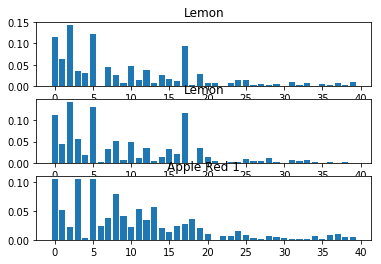

In [5]:
plot_items = embeddings[20:32:4,:]
plot_labels = labels[20:32:4]
Plots.plot_some_data(plot_items, plot_labels)

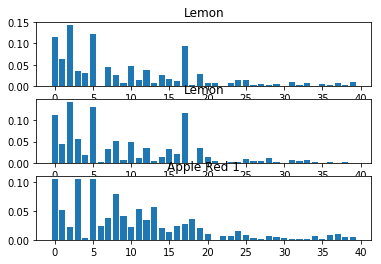

In [6]:
plot_items = (L @ embeddings[20:32:4,:].T).T
plot_labels = labels[20:32:4]
Plots.plot_some_data(plot_items, plot_labels)

Next we plot the L matrix. At initilization we expect to see the diagonal matrix, but as we update L, we hope to see something different. 

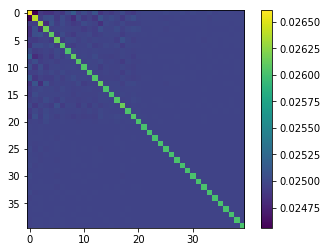

In [16]:
Plots.plot_kernel(L)

## Functions 2.0

In [13]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1 / 2 * np.nansum(np.square(xi - xj) / (xi + xj))

def distance(xi, X):
    """
    Chi square distance from one point xi, to all other points
    
    :param xi: Embedding       (1, D)
    :param X: Data             (N, D)
    :return: Distances         (1, N)
    
    """
    N, K = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances

def find_target_neighbors(X, Y):
    """
    Find target neighbours for all points
    
    :param X: Data Matrix      (N, D)
    :param Y: Labels           (1, N)
    :return: TN_lookup_table   (N, K)
    :return: TN_distance_table (N, K)
    """
    
    global TN_lookup_table
    global TN_distance_table
    
    N, _ = np.shape(X)
    TN_lookup_table = np.zeros((N, K))
    TN_distance_table = np.zeros((N, K))

    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        
        # Find distance from xi to all other points
        TN_Distances = distance(xi, X)
        TN_Indicies = np.argsort(TN_Distances)
        j = k = 0
        
        #Loop to add indicies of target neighbours to lookup table
        while j < K:
            # if yi and target neighbour have the same label AND it is not the same point
            if Y[TN_Indicies[k]] == yi and TN_Indicies[k] != i:
                # Add to lookup table and distance table
                TN_lookup_table[i, j] = TN_Indicies[k]
                TN_distance_table[i, j] = TN_Distances[TN_Indicies[k]]
                j += 1
            k += 1
    TN_lookup_table = TN_lookup_table.astype(int)
    return TN_lookup_table, TN_distance_table


def find_imposters(i, X, Y):
    """
    Find imposters for a given point in index i
    
    :param i: Index in data matrix 
    :param X: Data Matrix    (N, D)
    :param Y: Labels         (1, N)
    :return: imposters       (?, D)
    :return: imposters_dist  (1, D)
    """
    
    #Max margin = max distance of a target neighbour for that point + l
    max_dist = 0
    for TN in TN_lookup_table[i,:]:
        dist = chi_square_distance(L @ X[i], L @ X[TN])
        if dist > max_dist:
            max_dist = dist
    max_margin = max_dist + l
    #Find distances 
    distances = distance(X[i,:], X)
    imposters = np.array([0])
    for j, index in enumerate(np.argsort(distances)):
        if distances[j] > max_margin:
            break
        elif Y[i] != Y[index]:
            if not (max_margin > chi_square_distance(L @ X[i], L @ X[index])):
                print(max_margin, chi_square_distance(L @ X[i], L @ X[index]), distances[j])
            imposters = np.append(imposters, index)
    imposters.astype(int)
    return imposters[1:]

# Tau Function

def tau_function(X_Matrix, L_Matrix, i, j, alpha):
    N, D = np.shape(X_Matrix)
    numerator = 0
    denominator = 0
    for k in range(D):
        numerator +=   L_Matrix[alpha, k] * (X_Matrix[i, k] - X_Matrix[j, k])
        denominator += L_Matrix[alpha, k] * (X_Matrix[i, k] + X_Matrix[j, k])
    return numerator / denominator

def check(L_matrix, xi, xj, xk):
    return chi_square_distance(L @ xi, L @ xj) + l > chi_square_distance(L @ xi, L @ xk)

    

### PULL    
    
def Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta):
    N, D = np.shape(X_Matrix)
    elem = 0
    for i in range(N):
        for j in TN_lookup_table[i, :]:
            tau = tau_function(X_Matrix, L_Matrix, i, j, alpha)
            elem += 2 * tau * (X_Matrix[i, beta] - X_Matrix[j, beta]) - (tau**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
    return elem
            
    

def Pull(X_Matrix, L_Matrix):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Pull_matrix_element(X_Matrix, L_Matrix, alpha, beta)
    return gradient_matrix


### PUSH

def Push(X_Matrix, L_Matrix, Y):
    D, D = np.shape(L_Matrix)
    gradient_matrix = np.zeros((D,D))
    for alpha in range(D):
        for beta in range(D):
            gradient_matrix[alpha, beta] = Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta)
    return gradient_matrix


def Push_matrix_element(X_Matrix, L_Matrix, Y, alpha, beta):
    N, D = np.shape(X_Matrix)
    elem = 0
    for i in range(N):
        xi = X_Matrix[i,:]
        for j in TN_lookup_table[i, :]:
            imposters = find_imposters(i, X_Matrix, Y)
            for l_imposter in imposters:
                if check(L, X_Matrix[i],  X_Matrix[j],  X_Matrix[l_imposter]):
                    tauij = tau_function(X_Matrix, L_Matrix, i, j, alpha)
                    tauik = tau_function(X_Matrix, L_Matrix, i, l_imposter, alpha)
                    Lij = 2 * tauij * (X_Matrix[i, beta] - X_Matrix[j, beta])          - (tauij**2) * (X_Matrix[i, beta] + X_Matrix[j, beta])
                    Lik = 2 * tauik * (X_Matrix[i, beta] - X_Matrix[l_imposter, beta]) - (tauik**2) * (X_Matrix[i, beta] + X_Matrix[l_imposter, beta])
                    elem += Lij - Lik
                else:
                    print(i, j, l_imposter)
    return elem

def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L)
    

In [14]:
TN_lookup_table, TN_distance_table = find_target_neighbors(embeddings[0:30], labels[0:30])

In [15]:
ITERATIONS = 10

for i in range(ITERATIONS):
    print(i)
    Gt = (1 - mu) * Pull(embeddings[0:30], L) + mu * Push(embeddings[0:30], L, labels[0:30])
    update_step(Gt)
    print(Gt)
    print(L)
    print("\n")

0
[[ 7.47920706e-02 -9.78506128e-01 -3.30520644e-01 ... -1.11191190e-03
  -2.86782156e-02 -2.72068617e-02]
 [-1.77098677e-01  4.84711732e-02 -7.18697919e-02 ... -2.08133379e-03
  -6.48330028e-03 -1.10361743e-03]
 [-2.21167333e-02  4.76466956e-03  1.45358783e-02 ... -8.46856115e-03
  -2.32866250e-03 -7.73091778e-03]
 ...
 [-2.31542577e+00 -3.05692460e+00 -3.57974777e+00 ...  1.26653995e-01
  -1.93972756e-01 -8.66444333e-02]
 [-2.03577734e+00 -2.59395931e+00 -2.55160391e+00 ... -1.06041855e-01
   1.09207594e-01 -9.17466245e-02]
 [-2.27384964e+00 -1.58163252e+00 -2.80741854e+00 ... -5.08562991e-02
  -1.10723768e-01  1.06710970e-01]]
[[0.06514608 0.02399116 0.02397562 ... 0.02396772 0.02396838 0.02396835]
 [0.02397407 0.06515358 0.02397155 ... 0.02396988 0.02396998 0.02396985]
 [0.02397072 0.02397007 0.06515677 ... 0.02397039 0.02397024 0.02397037]
 ...
 [0.02400946 0.02402727 0.02403984 ... 0.0651053  0.02395858 0.02395601]
 [0.02400586 0.02401927 0.02401825 ... 0.02395958 0.06511488 0.02

KeyboardInterrupt: 

In [32]:
def Lijalphabeta(xi, xj, alpha, beta):
    tau = tau_function(xi, xj, alpha)
    return 2 * (xi[beta] - xj[beta]) * (tau) - (xi[beta] + xj[beta]) * (tau)**2

def Push_Gradient_Matrix(X, Y):
    N, D  = np.shape(X)
    Push_Matrix = np.zeros((D,D))
    for alpha in range(D):
        print(alpha)
        for beta in range(D):
            Push_Matrix[alpha, beta] = Push(X, Y, alpha, beta) 
    return Push_Matrix

def Push(X, Y, alpha, beta):
    N, D = np.shape(X)
    Gradient_alpha_beta = 0
    for i in range(N):
        xi = X[i, :]
        imposters, _ = find_imposters(i, X, Y)
        N_Imposters, _ = np.shape(imposters)
        for j in range(K):
            xj = X[int(TN_lookup_table[i,j]),:]
            for l_imposter in range(N_Imposters):
                xl = imposters[l_imposter]
                Gradient_alpha_beta += Lijalphabeta(xi, xj, alpha, beta) - Lijalphabeta(xi, xl, alpha, beta)
    return Gradient_alpha_beta
                

In [36]:
X = embeddings
Y = np.array(labels)

In [37]:
TN_lookup_table, TN_distance_table = find_target_neighbors(X[0:30], Y[0:30])

In [38]:
Gt = (1 - mu) * Pull_Gradient_Matrix(X[0:30]) + mu * Push_Gradient_Matrix(X[0:30], Y[0:30])

0
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40

N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
4
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40

N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
10
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 4

N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)
N imposters (0, 40)


KeyboardInterrupt: 

In [20]:
update_step(Gt)

In [18]:
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L)

In [981]:
im,_ = find_imposters(0, X, Y)
np.shape(im)

(95, 40)

In [11]:
def objective_function(X, Y):
    global TN_Indicies
    N, D = np.shape(X)
    Pull = np.zeros((D,D))
    Gradient = np.zeros((D,D))
    for i in range(N):
        xi = X[i,:]
        for j in range(K):
            xj = X[int(TN_lookup_table[i, j]),:]
            imposters, _ = find_imposters(i, X, Y)
            Pull += chi_gradient(xi,xj)
            Push = np.zeros((D,D))
            print(len(imposters))
            for k in range(len(imposters)):
                xk = imposters[k,:]
                epsilon = np.sum(chi_square_distance(L @ xi, L @ xj) + l - chi_square_distance(L @ xi, L @ xk))
                if (epsilon >= 0):
                    Push += chi_gradient(xi,xj) - chi_gradient(xi,xk)
            Gradient = (1 - mu) * Pull + mu * Push
    return Gradient


In [35]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1/2 * np.nansum(np.square(xi - xj) / (xi + xj))

def distance(xi, X):
    N, K = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances


def find_target_neighbors(X, Y):
    global TN_lookup_table
    global TN_distance_table
    
    N, _ = np.shape(X)
    TN_lookup_table = np.zeros((N, K))
    TN_distance_table = np.zeros((N, K))

    for i in range(N):
        xi = X[i,:]
        yi = Y[i]
        TN_Distances = distance(xi, X)
        TN_Indicies = np.argsort(TN_Distances)
        j = k = 0
        while j < K:
            if Y[TN_Indicies[k]] == yi:
                TN_lookup_table[i, j] = TN_Indicies[k]
                TN_distance_table[i, j] = TN_Distances[TN_Indicies[k]]
                j += 1
            k += 1
    return TN_lookup_table, TN_distance_table

def find_imposters(i, X, Y):
    max_margin = np.max(TN_distance_table[i, :]) + l
    candidate_imposters = X[np.where(Y[i] != Y)]
    imposters_dist = distance(X[i,:], candidate_imposters)
    imposters = candidate_imposters[np.where(imposters_dist < max_margin)]
    imposters_dist = imposters_dist[np.where(imposters_dist < max_margin)]
    print("N imposters {}".format(np.shape(imposters)))
    return imposters, imposters_dist

def chi_gradient(xi, xj):
    Gradient = np.zeros((D,D))
    xBARi = L @ xi
    xBARj = L @ xj
    for p in range(D):
        tijp = (xBARi[p] - xBARj[p]) / (xBARi[p] + xBARj[p])
        for q in range(D):
            Gradient[p,q] = tijp * (xi[q] - xj[q]) - 1/2 * (tijp ** 2) * (xi[q] + xj[q])
    return Gradient


def objective_function(X, Y):
    global TN_Indicies
    N, D = np.shape(X)
    outer_gradient = np.zeros((D,D))
    for i in range(N):
        
        xi = X[i,:]
        print("{} out of {}".format(i, N))
        for j in range(K):
            xj = X[int(TN_lookup_table[i, j]),:]
            imposters, _ = find_imposters(i, X, Y)
            
            outer_gradient += (1-mu) * chi_gradient(xi,xj)            
            inner_gradient = np.zeros((D,D))
            print("Imposters: {}".format(len(imposters)))
            for k in range(len(imposters)):
                xk = imposters[k,:]
                inner = softmax(l + chi_gradient(xi,xj) - chi_gradient(xi,xk), axis=1)
                #inner[inner < 0] = 0
                #inner_gradient += inner
            outer_gradient += mu * inner_gradient
    return outer_gradient

def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L, axis=1)

In [729]:
#from scipy.special import softmax
#X = embeddings
#Y = np.array(labels)
#TN_lookup_table, TN_distance_table = find_target_neighbors(X[0:30], Y[0:30])



In [234]:
def objective_function(X, Y):
    N, D = np.shape(X)
    Loss = 0
    for i in range(N):
        for j in range(K):
            Loss += TN_distance_table[i, j]
            imposters, imposters_dist = find_imposters(i, (L @ X.T).T, Y)
            
            inner_loss = 0
            for k in range(len(imposters)):
                inner_loss += max(0, l + TN_distance_table[i, j] - imposters_dist[k])
            Loss += mu * inner_loss
            
    return Loss



(40, 40)
(100, 40)


In [362]:
def chi_gradient(xi, xj):
    Gradient = np.zeros((D,D))
    xBARi = L @ xi
    xBARj = L @ xj
    for p in range(D):
        tijp = (xBARi[p] - xBARj[p]) / (xBARi[p] + xBARj[p])
        for q in range(D):
            Gradient[p,q] = tijp * (xi[q] - xj[q]) - 1/2 * (tijp ** 2) * (xi[q] + xj[q])
    return Gradient


In [367]:
def objective_function(X, Y):
    global TN_Indicies
    N, D = np.shape(X)
    outer_gradient = np.zeros((D,D))
    Loss = 0
    for i in range(N):
        
        xi = X[i,:]
        print("{} out of {}".format(i, N))
        for j in range(K):
            Loss += TN_distance_table[i, j]
            xj = X[int(TN_lookup_table[i, j]),:]
            imposters, imposters_dist = find_imposters(i, (L @ X.T).T, Y)
            
            outer_gradient += chi_gradient(xi,xj)            
            inner_gradient = np.zeros((D,D))
            inner_loss = 0
            print("Imposters: {}".format(len(imposters)))
            for k in range(len(imposters)):
                xk = imposters[k,:]
                inner = l + chi_gradient(xi,xj) - chi_gradient(xi,xk)
                inner[inner < 0] = 0
                inner_gradient += inner
                inner_loss += max(0, l + TN_distance_table[i, j] - imposters_dist[k])
            outer_gradient += mu * inner_gradient
            Loss += mu * inner_loss
    return outer_gradient, Loss
                
l = 100
Gradient = objective_function(X[0:5], Y[0:5])
update_step(Gradient)

0 out of 5
Imposters: 0
Imposters: 0
Imposters: 0
Imposters: 0
1 out of 5
Imposters: 0
Imposters: 0
Imposters: 0
Imposters: 0
2 out of 5
Imposters: 0
Imposters: 0
Imposters: 0
Imposters: 0
3 out of 5
Imposters: 0
Imposters: 0
Imposters: 0
Imposters: 0
4 out of 5
Imposters: 0
Imposters: 0
Imposters: 0
Imposters: 0


TypeError: can't multiply sequence by non-int of type 'float'

In [347]:
update_step(Gradient)

array([[0.06923972, 0.02831155, 0.02241667, ..., 0.02438497, 0.02411745,
        0.02425897],
       [0.02667678, 0.06921473, 0.02699554, ..., 0.02392611, 0.02379456,
        0.02389347],
       [0.02034335, 0.02849163, 0.06638415, ..., 0.02436977, 0.0241486 ,
        0.02421861],
       ...,
       [0.02420594, 0.02219822, 0.02400722, ..., 0.0651963 , 0.02372348,
        0.02389569],
       [0.02093386, 0.01936849, 0.02456368, ..., 0.02355559, 0.06562656,
        0.02388559],
       [0.02378442, 0.02417912, 0.02432952, ..., 0.02390779, 0.02401901,
        0.06534681]])

array([[ 22.95562957,  -9.13630354,  31.86982286, ...,  10.79625281,
         12.1342218 ,  10.76504212],
       [-32.21002285,  14.96288563,  -8.89893819, ...,  12.75880955,
         13.39482025,  12.80050225],
       [ 44.84479625, -14.62426536,  20.87153686, ...,  10.07318715,
         11.85398762,  10.60962697],
       ...,
       [-72.44780079,  20.97371368, -18.37007976, ...,  12.70058872,
         13.42894891,  12.49432922],
       [-54.09696998,  32.77171743, -25.63091862, ...,  14.24498709,
         11.89347458,  12.28051843],
       [-23.51874467,  18.50585087,   0.65795167, ...,  12.81141906,
         12.3453834 ,  12.09895908]])

In [346]:
from scipy.special import softmax
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    new_L = L - alpha * G
    L = softmax(new_L, axis=0)

In [ ]:
# TODO:  Run this in loop over all vectors in X 
X = embeddings
Y = np.array(labels)

l = 0.009
N_Iterations = 10
Loss_History = []
find_target_neighbors(X, Y)

for i in range(N_Iterations):
    Gradient_L, Loss = gradient_loss(L, X, Y)
    update_step(Gradient_L)
    Loss_History.append(Loss)
    

## Functions

Chi square distance, as described in equation (3) in the non-linear metric learning paper

In [125]:
def chi_square_distance(xi, xj):
    """
    Chi square distance

    :param xi: Embedding       (1, D)
    :param xj: Target Neighbor (1, D)
    :return: Distance
    """
    return 1/2 * np.nansum(np.square(xi - xj) / (xi + xj))

In [126]:
def gradient_chi(L, xi, xj):
    """
    Gradient of the Chi Square Distance
    
    :param L: Transformation Matrix (D, D)
    :param xi: Data vector i (1, D) 
    :param xj: Data Vector j (1, D) 
    :return: Gradient (D, D)
    """
    D = np.shape(L)[1]
    grad = np.zeros((D, D))
    
    xbari = L @ xi
    xbarj = L @ xj
    for p in range(D):
        t = (xbari[p] - xbarj[p]) / (xbari[p] + xbarj[p])
        for q in range(D):
            grad[p,q] = t*(xi[q]-xj[q])-0.5*(t**2)*(xi[q]+xj[q])
    return grad

Loss function as described in equaltion (5) in the paper

In [127]:
def loss_function(xi, xj, xk):
    """
    Loss function as described in the paper

    :param xi: One embedding        (D, 1)
    :param xj: K target neighbors   (D, K)
    :param xk: Unknown imposters    (D, ?)

    :return: Loss for one embedding
    """

    _, K = np.shape(xj)
    _, imposter = np.shape(xk)
    sum = 0

    for j in range(K):
        sum += chi_square_distance(L @ xi, L @ xj[:, j])
        inner_sum = 0
        for k in range(imposter):
            inner_sum += max(0, l + chi_square_distance(xi, xj[:, j]) - chi_square_distance(xi, xk[:, k]))
        sum += mu * inner_sum
    return sum


In [128]:
def gradient_loss(L, X, Y):
    """
    Loss function as described in the paper

    :param L: Transformation Matrid (D, D)
    :param X: Data Matrix (N, D)
    :param Y: Labels (1, N)

    :return: Gradient Loss (D, D) and loss
    """
    
    N, D = np.shape(X)
    Gradient_sum = np.zeros((D, D))
    Loss = 0
    for i in range(N):
        xj, xk = find_triplets(X[i], Y[i], X, Y)
        K, _ = np.shape(xj)
        imposter, _ = np.shape(xk)
        
        for j in range(K):
            Gradient_sum += gradient_chi(L, L @ X[i], L @ xj[j, :])
            Loss += chi_square_distance(L @ X[i], L @ xj[j, :])
            inner_sum = np.zeros((D, D))
            inner_loss = 0
            for k in range(imposter):
                if(l + chi_square_distance(L @ X[i], L @ xj[j,:]) - chi_square_distance(L @ X[i], L @ xk[k,:]) > 0):
                    inner_sum += gradient_chi(L, L @ X[i], L @ xj[j, :]) - gradient_chi(L, L @ X[i], L @ xk[k,:])
                    inner_loss += max(0, l + chi_square_distance(L @ X[i], L @ xj[j, :]) - chi_square_distance(L @ X[i], L @ xk[k,:]))
                Gradient_sum += mu * inner_sum
                Loss += mu * inner_loss
    return Gradient_sum, Loss

Functions to find triples. Distance function need to be changed, to find the distance through the L plane, and not just in the euclidean space. 

In [129]:
def distance(xi, X):
    """
    :param xi: Embedding vector                        (1, D)
    :param X: Data matrix without embedding vector (N - 1, D)
    :return: Distance vector                       (1, N - 1)
    """
    N, D = np.shape(X)
    Distances = np.zeros(N)
    for i in range(N):
        Distances[i] = chi_square_distance(L @ xi, L @ X[i, :])
    return Distances


## Update 
def find_triplets(xi, yi, X, y):
    """
    Given some vector xi and corresponding label yi, find target neighbors and imposters

    :param xi: Embedding vector                                  (1, D)
    :param yi: Label for embedding vector
    :param X: Data matrix without embedding vector           (N - 1, D)
    :return: target_neighbors and imposters for embedding (K, D) (?, D)
    """
    candidate_target_neighbors = X[np.where(yi == y)]
    imposters = X[np.where(yi != y)]
    
    target_neighbors_dist = distance(xi, candidate_target_neighbors)
    imposters_dist = distance(xi, imposters)
    
    
    # Find K target neighbors
    target_neighbors = np.zeros((1, D))
    chosen_distances = np.zeros(K)
    for i in range(K):
        min_index = np.argmin(target_neighbors_dist)
        target_neighbors = np.vstack((target_neighbors, candidate_target_neighbors[min_index]))
        chosen_distances[i] = target_neighbors_dist[min_index]
        target_neighbors_dist = np.delete(target_neighbors_dist, (min_index), axis=0)
    target_neighbors = target_neighbors[1:, :]

    # Find ? imposters
    max_target_dist = np.max(chosen_distances)
    #print(max_target_dist)
    imposters = imposters[np.where(imposters_dist < max_target_dist + l)]
    #print("N_ Imposters{}".format(np.shape(imposters)))
    return target_neighbors, imposters

Next we define the update step for L given some gradient. <br/>

Additinally, it might be worth considering updating alpha. In one of the papers they state that "*(...) at each iteration, we increased α by a factor of 1.01 if the loss function decreased and decreased α by a factor of 0.5 if the loss function increased.*"


In [130]:
from scipy.special import softmax
def update_step(G):
    """
    Update L
    
    :param G: Computed gradient for a given iteration
    """
    global L
    
    # Map new L into correct space  
    new_L = L - alpha * G
    #new_L = softmax(new_L, axis=0)
    
    #Update L
    L = new_L

## Run LMNN

In [132]:
# TODO:  Run this in loop over all vectors in X 
X = embeddings
Y = np.array(labels)

l = 0.009
Loss_History = []
for i in range(10):
    Gradient_L, Loss = gradient_loss(L, X, Y)
    update_step(Gradient_L)
    Loss_History.append(Loss)
    print(Loss)
    
    


KeyboardInterrupt: 

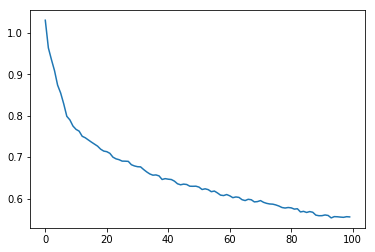

In [64]:
Plots.plot_loss_curve(Loss_History)

In [81]:
i = 0
j = 7

xi = X[i,:]
xj = X[j,:]
print("{}, {}".format(Y[i], Y[j]))
print("Original Distance {}".format(chi_square_distance(xi, xj)))
print("New Distance {}".format(chi_square_distance(L @ xi, L @ xj)))
print("Ratio {}".format(chi_square_distance(xi, xj) / chi_square_distance(L @ xi, L @ xj)))

Banana Lady Finger, Cherry 1
Original Distance 0.11778032034635544
New Distance 0.02440869898034931
Ratio 4.8253419996361435


In [87]:
distance(xi, X)
np.shape(X)
distance(xi, X)
distance(xi, X) / distance(L @ xi, (L @ X.T).T)

array([0.        , 2.14815183, 2.12024717, 1.81142006, 2.59445222,
       3.76575949, 3.58055092, 3.29381402, 3.35606005, 3.34107501,
       2.92855657, 2.88903219, 2.89475611, 3.37045307, 2.66074473,
       2.73659954, 3.03019274, 3.09766276, 2.82431918, 2.78508633,
       1.77161996, 1.80270919, 1.74621882, 1.80618766, 1.66111748,
       2.60083437, 2.35512593, 2.26508175, 2.67142406, 2.75339249,
       3.19351532, 3.23413323, 3.33720641, 3.02650751, 3.7076403 ,
       2.74123659, 2.99236003, 2.59595255, 3.16515769, 3.1369697 ,
       3.13289294, 3.19923703, 3.07147443, 2.95363006, 3.03114001,
       3.08247312, 2.32321017, 2.76814439, 2.63187729, 2.61108034,
       2.717236  , 2.83252667, 3.27295667, 2.99605675, 2.90414176,
       2.28191235, 2.42422312, 2.91500086, 2.67402691, 2.81908461,
       2.92595397, 3.28361787, 3.60019523, 3.10544533, 3.21808953,
       2.67442039, 2.70934735, 2.53489964, 2.88064716, 2.80123732,
       2.89154395, 3.19412033, 3.38382418, 3.32670707, 3.05167